In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

In [2]:
# To use the model later without retraining:
from tensorflow.keras.models import load_model
model = load_model('D:/DATASET/Models/model_ballooning.h5')

In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define preprocessing function
def preprocess_image(image):
    # Convert to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Apply Gaussian Blur to highlight white regions
    blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)
    # Normalize the image
    blurred_image = blurred_image / 255.0
    # Expand the dimensions to fit model input
    return np.stack((blurred_image,)*3, axis=-1)  # Stack grayscale image to have three channels

# Setup data generator
datagen = ImageDataGenerator(preprocessing_function=preprocess_image)

# Load ResNet50 base model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(185, 93, 3))

# Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1, activation='sigmoid')(x)  # Sigmoid for binary classification

model = Model(inputs=base_model.input, outputs=x)
model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Prediction function
def predict_image(image_path, model):
    image = cv2.imread(image_path)
    crops = []

    # Crop the image into sections of 185x93
    for y in range(0, image.shape[0], 93):
        for x in range(0, image.shape[1], 185):
            crop = image[y:y+93, x:x+185]
            if crop.shape[0] == 93 and crop.shape[1] == 185:
                crops.append(crop)

    scores = []
    fig, axs = plt.subplots(1, len(crops), figsize=(20, 5))

    for i, crop in enumerate(crops):
        processed_crop = preprocess_image(crop)
        processed_crop = np.expand_dims(processed_crop, axis=0)
        probability = model.predict(processed_crop)[0]
        
        # Convert probability to score
        score = 1 if probability <= 0.5 else 0
        scores.append(score)
        
        # Display each crop and score
        axs[i].imshow(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
        axs[i].title.set_text(f'Score: {score}')
        axs[i].axis('off')

    plt.show()
    average_score = np.mean(scores)
    print(f'Average ballooning score for the image: {average_score:.2f}')
    return scores, average_score

ValueError: in user code:

    File "C:\Users\JUHI\anaconda3\lib\site-packages\keras\engine\training.py", line 2169, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\JUHI\anaconda3\lib\site-packages\keras\engine\training.py", line 2155, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\JUHI\anaconda3\lib\site-packages\keras\engine\training.py", line 2143, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\JUHI\anaconda3\lib\site-packages\keras\engine\training.py", line 2111, in predict_step
        return self(x, training=False)
    File "C:\Users\JUHI\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\JUHI\anaconda3\lib\site-packages\keras\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model" is incompatible with the layer: expected shape=(None, 185, 93, 3), found shape=(None, 93, 185, 3)


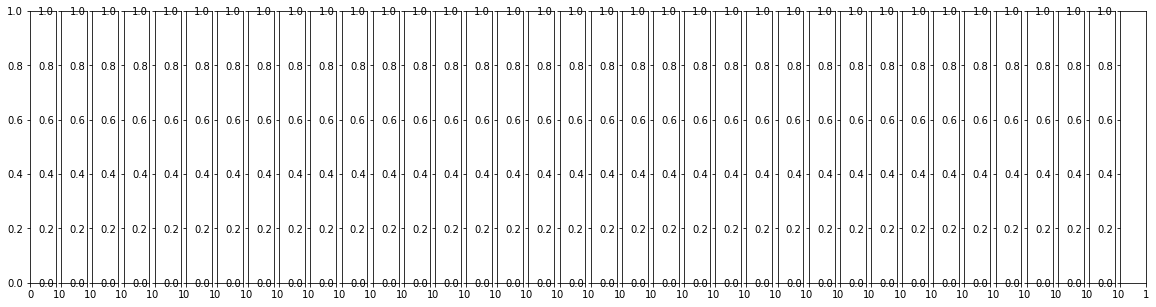

In [17]:
image_path = "D:/scoring/Z_n40x3.jpg"
scores, average_score = predict_image(image_path, model)

In [5]:
# Define preprocessing function
def preprocess_image(image):
    # Convert to grayscale (assuming image is loaded in color)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Apply Gaussian Blur
    image = cv2.GaussianBlur(image, (5, 5), 0)
    # Expand the dimensions to fit model input
    return np.stack((image,)*3, axis=-1)  # Stack grayscale image to have three channels

# Configure data generator
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_image,
    rescale=1./255
)

In [6]:
# Predict on 299x299 dimension images to check the model performance

import cv2
import numpy as np
import matplotlib.pyplot as plt

def predict_single_image(image_path, model):
    # Load the image
    image = cv2.imread(image_path)
    
    # Preprocess the image
    processed_image = preprocess_image(image)
    processed_image = np.expand_dims(processed_image, axis=0)  # Add batch dimension
    
    # Predict the ballooning score
    score = model.predict(processed_image)[0]
    
    # Display the image and its predicted score
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for displaying
    plt.title(f'Predicted Ballooning Score: {score[0]:.2f}')
    plt.axis('off')  # Hide axes
    plt.show()
    
    return score

1/1 [==============================] - 1s 558ms/step


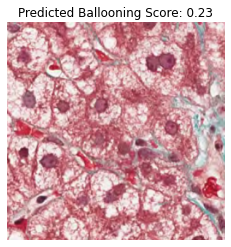

BALLOONING SCORE:  [0.23039839]


In [12]:
image_path = "D:/DATASET/CNN/ballooning/train/0/174_146_105.png"
score = predict_single_image(image_path, model)
print ("BALLOONING SCORE: ", score)

In [14]:
# Predict on Large images 1853x932 dimension

import cv2
import numpy as np
import matplotlib.pyplot as plt

def predict_and_visualize(image_path, model):
    image = cv2.imread(image_path)
    step_size = 299  # Since target size during training is 299x299
    scores = []
    fig, ax = plt.subplots(nrows=int(np.ceil((image.shape[0]-step_size)/step_size)), ncols=int(np.ceil((image.shape[1]-step_size)/step_size)), figsize=(20, 10))

    idx = 0
    for y in range(0, image.shape[0] - step_size, step_size):
        for x in range(0, image.shape[1] - step_size, step_size):
            crop = image[y:y+step_size, x:x+step_size]
            processed_crop = preprocess_image(crop)
            processed_crop = np.expand_dims(processed_crop, axis=0)
            score = model.predict(processed_crop)[0]
            scores.append(score)
            
            # Plotting the crop with its score
            ax_idx = np.unravel_index(idx, ax.shape)
            ax[ax_idx].imshow(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
            ax[ax_idx].title.set_text(f'Score: {score[0]:.2f}')
            ax[ax_idx].axis('off')
            idx += 1

    plt.tight_layout()
    plt.show()

    average_score = np.mean(scores)
    print(f'Average ballooning score for the image: {average_score}')

    return scores, average_score

1/1 [==============================] - 1s 577ms/step


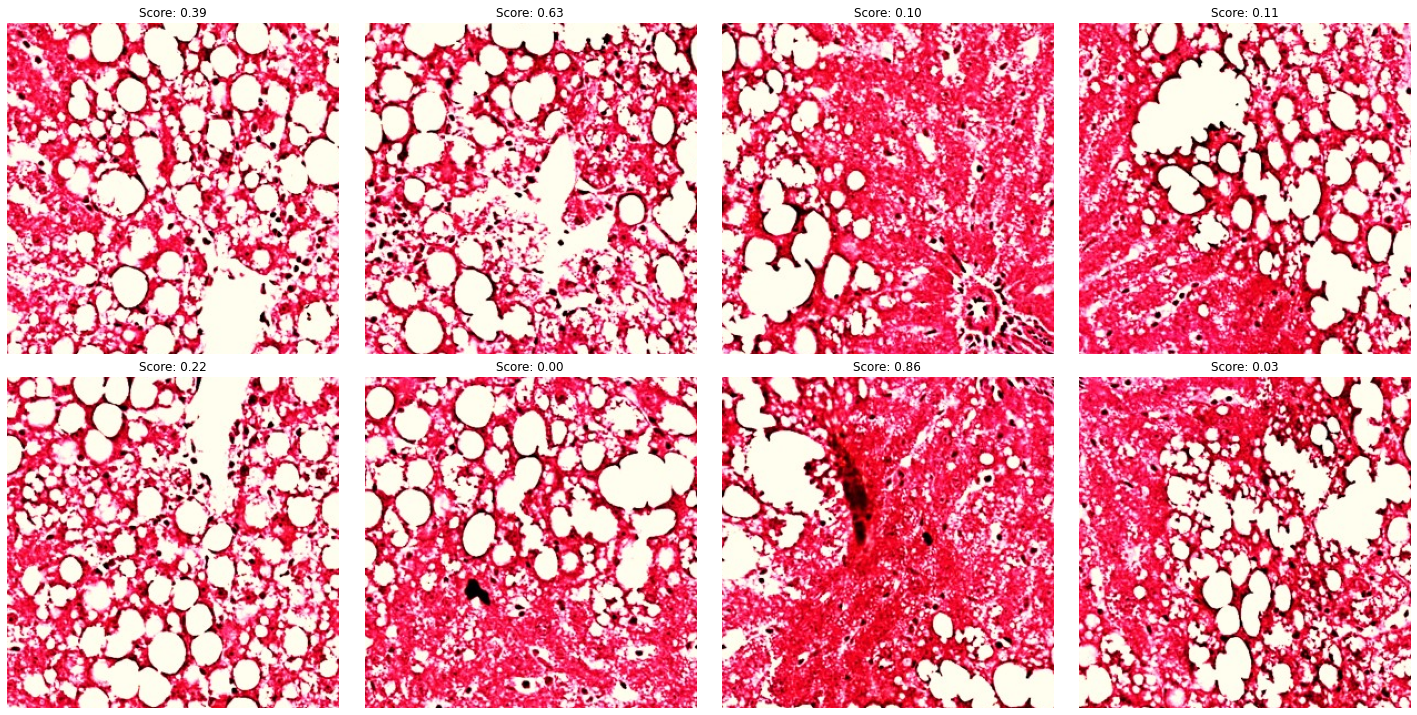

Average ballooning score for the image: 0.2929476797580719


In [15]:
image_path = "D:/scoring/Z_n40x3.jpg"
scores, average_score = predict_and_visualize(image_path, model)

In [ ]:
# Visualization

# Plot training accuracy and loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()